# Hybrid/Hamiltonian Monte Carlo

Leap frog algorithm

In [28]:
def energy_grad(thetas, phis):
    theta_cos = np.cos(thetas)
    theta_sin = np.sin(thetas)
    phi_cos = np.cos(phis)
    phi_sin = np.sin(phis)
    
    left_theta_cos = np.roll(theta_cos, 1)
    left_theta_sin = np.roll(theta_sin, 1)
    right_theta_cos = np.roll(theta_cos, -1)
    right_theta_sin = np.roll(theta_sin, -1)
    
    left_phi_cos = np.roll(phi_cos, 1)
    left_phi_sin = np.roll(phi_sin, 1)
    right_phi_cos = np.roll(phi_cos, -1)
    right_phi_sin = np.roll(phi_sin, -1)
    
    d_left_by_theta = -left_theta_cos*theta_sin*phi_sin*left_phi_sin + theta_cos*phi_sin*left_theta_sin*left_phi_sin
    d_left_by_phi = -left_phi_cos*phi_sin + theta_cos*phi_cos*left_theta_cos*left_phi_sin + phi_cos*theta_sin*left_theta_sin*left_phi_sin
    
    d_right_by_theta = -right_theta_cos*theta_sin*phi_sin*right_phi_sin + theta_cos*phi_sin*right_theta_sin*right_phi_sin
    d_right_by_phi = -right_phi_cos*phi_sin + theta_cos*phi_cos*right_theta_cos*right_phi_sin + phi_cos*theta_sin*right_theta_sin*right_phi_sin
    
    return d_left_by_theta+d_right_by_theta, d_left_by_phi+d_right_by_phi

In [29]:
def next_velocity(velocity, energy_grad, eps):
    return velocity - eps/2*energy_grad

In [30]:
def next_state(state, velocity, eps):
    return state + eps*velocity

In [31]:
def leap_frog(thetas, phis, init_theta_vel, init_phi_vel, eps):
    # Compute energy landscape gradient
    theta_grads, phi_grads = energy_grad(thetas, phis)
    
    # Compute the half-step velocity of the free variables
    theta_vel = next_velocity(init_theta_vel, theta_grads, eps)
    phi_vel = next_velocity(init_phi_vel, phi_grads, eps)
    
    # Compute the next trial state
    theta_trial = next_state(thetas, theta_vel, eps)
    phi_trial = next_state(phis, phi_vel, eps)
    
    # Compute the velocity of the trial state
    theta_trial_grads, phi_trial_grads = energy_grad(
        theta_trial, phi_trial)
    theta_trial_vel = next_velocity(theta_vel, theta_trial_grads, eps)
    phi_trial_vel = next_velocity(phi_vel, phi_trial_grads, eps)
    
    return theta_trial, phi_trial, theta_trial_vel, phi_trial_vel

# 1D lattice of spins

In [34]:
def random_velocity(N):
    return np.random.randn(N)

In [40]:
def momentum_energy(theta_vels, phi_vels):
    theta_energies = np.sum(0.5*theta_vels**2)
    phi_energies = np.sum(0.5*phi_vels**2)
    return theta_energies + phi_energies

In [157]:
def internal_energy(thetas, phis):
    theta_cos = np.cos(thetas)
    theta_sin = np.sin(thetas)
    phi_cos = np.cos(phis)
    phi_sin = np.sin(phis)
    
    left_theta_cos = np.roll(theta_cos, 1)
    left_theta_sin = np.roll(theta_sin, 1)
    left_phi_cos = np.roll(phi_cos, 1)
    left_phi_sin = np.roll(phi_sin, 1)
    
    energies = phi_cos*left_phi_cos + theta_cos*left_theta_cos*phi_sin*left_phi_sin + theta_sin*phi_sin*left_theta_sin*left_phi_sin
    
    return -energies.sum()

In [158]:
def total_energy(thetas, phis, theta_vels, phi_vels):
    return internal_energy(thetas, phis) + momentum_energy(theta_vels, phi_vels)

In [159]:
def acceptance(thetas, phis, theta_vels, phi_vels,
               trial_thetas, trial_phis, trial_theta_vels, trial_phi_vels, beta):
    energy_diff = total_energy(thetas, phis, theta_vels, phi_vels) - total_energy(trial_thetas, trial_phis, trial_theta_vels, trial_phi_vels)
    energy_acceptance = np.exp(energy_diff * beta)
    
    return np.random.uniform(0,1) < energy_acceptance

In [223]:
def metropolis_energy(thetas, phis, spin_idx):
    left = -1 if spin_idx == 0 else spin_idx -1
    right = 0 if spin_idx ==(len(thetas)-1) else spin_idx+1
    
    this_theta_cos = np.cos(thetas[spin_idx])
    this_theta_sin = np.sin(thetas[spin_idx])
    left_theta_cos = np.cos(thetas[left])
    left_theta_sin = np.sin(thetas[left])
    right_theta_cos = np.cos(thetas[right])
    right_theta_sin = np.sin(thetas[right])
    
    energy = this_theta

In [ ]:
def metropolis(initial_thetas, initial_phis, beta, N):
    # system size
    size = initial_thetas.size
    
    # copy in initial state
    thetas = np.copy(initial_thetas)
    phis = np.copy(initial_phis)
    trial_thetas = np.copy(initial_thetas) # will be replaced
    trial_phis = np.copy(initial_phis) # will be replaced
    
    for i in range(N):
        spin_idx = np.random.randint(size)
        
        this_theta = thetas[spin_idx]
        this_phi = phis[spin_idx]
        

In [201]:
def hmc(initial_thetas, initial_phis, eps, n, beta, N):
    # system size
    size = initial_thetas.size
    
    # track acceptance
    accepts = 0
    
    # track internal energy
    energy = np.zeros(N)
    
    # Copy in initial state
    thetas = np.copy(initial_thetas)
    phis = np.copy(initial_phis)
    trial_thetas = np.copy(initial_thetas) # will be replaced
    trial_phis = np.copy(initial_phis) # will be replaced
    
    
    for i in range(N):
        trial_thetas = thetas
        trial_phis = phis
        
        # Compute initial velocites
        theta_vels = random_velocity(size)
        phi_vels = random_velocity(size)
        trial_theta_vels = np.copy(theta_vels)
        trial_phi_vels = np.copy(phi_vels)
        
        # Take n leap frog steps
        for step in range(n):
            trial_thetas, trial_phis, trial_theta_vels, trial_phi_vels = leap_frog(
                trial_thetas, trial_phis, trial_theta_vels, trial_phi_vels, eps)
                
        # Accept new position?
        if acceptance(thetas, phis, theta_vels, phi_vels, trial_thetas, trial_phis, trial_theta_vels, trial_phi_vels, beta):
            thetas = trial_thetas
            phis = trial_phis
            accepts += 1
        energy[i] = internal_energy(thetas, phis)
    return thetas, phis, accepts/N, energy

# Try it

In [202]:
systemsize = 50

In [203]:
thetas = np.random.uniform(0, 2*np.pi, size=systemsize)
phis = np.random.uniform(0, np.pi, size=systemsize)

In [217]:
t, p, acc, energy = hmc(thetas, phis, 0.001, 50, 1e100, 10000)

In [218]:
print(acc)

0.0388


In [219]:
x = np.cos(t) * np.sin(p)
y = np.sin(t) * np.sin(p)
z = np.cos(p)

In [220]:
import matplotlib.pyplot as plt
%matplotlib inline

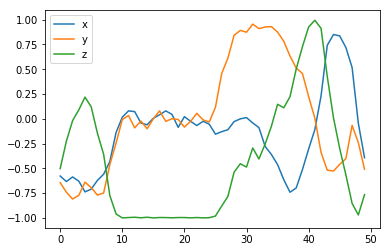

In [221]:
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
plt.legend()

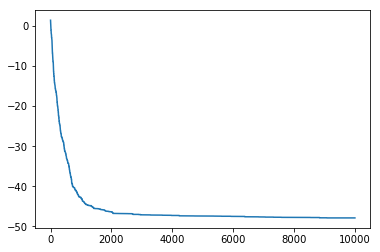

In [222]:
plt.plot(energy)

In [224]:
from mpl_toolkits.mplot3d import Axes3D

In [234]:
np.linspace(1,5,5)

array([ 1.,  2.,  3.,  4.,  5.])

In [253]:
%matplotlib inline

(-25.0, 25.0)

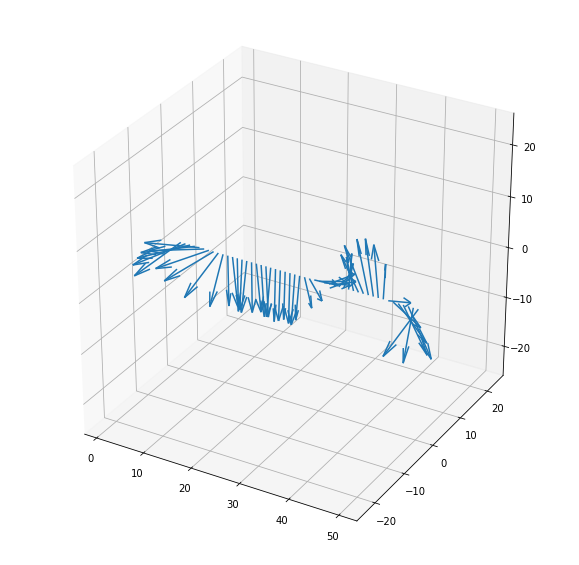

In [254]:
fg = plt.figure(figsize=(10,10))
ax = fg.gca(projection='3d')
ax.quiver(np.linspace(1, systemsize, systemsize),
          np.zeros(systemsize), np.zeros(systemsize), x, y, z,
          length=10)
ax.set_ylim(-systemsize/2, systemsize/2)
ax.set_zlim(-systemsize/2, systemsize/2)